In [1]:
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from Extract_Observation_Rh import extract_observation_rh
from Extract_Simulated_bt import extract_simulated_bt
print(tf.__version__)

2.4.1


In [2]:
# 获取模拟亮温数据
# 模拟亮温通过Fortran和IDL程序计算得到
Years = ['1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006',
         #'2007', '2008', '2009', '2010'
        ]
train_data = extract_simulated_bt(Years)
train_data.drop(['51.250', '52.280', '53.850', '54.940', '56.660', '57.290', '58.800'], axis=1, inplace=True)
print(f'train_data shape is {train_data.shape}')

train_data shape is (7006, 5)


In [3]:
# 模拟亮温数据归一化
def norm(x):
    return (x - x.describe().transpose()['mean']) / x.describe().transpose()['std']
train_data = norm(train_data)
train_data = train_data.round(3)

In [4]:
for i in train_data.index:
    x = train_data.loc[i] > 1
    if x[0] and x[1] and x[2] and x[3] and x[4]:
        train_data.drop(i, inplace=True)


In [5]:
# 获取观测相对湿度数据
train_labels = extract_observation_rh(Years)
# train_labels.drop(train_labels.columns[27:], axis=1, inplace=True)
# train_labels = norm(train_labels)
train_labels = train_labels.round(3)*100

print(f'train_labels shape is {train_labels.shape}')

train_labels shape is (6610, 47)


In [6]:
for i in train_labels.index:
    if train_labels.loc[i].mean() > 80 :
        train_labels.drop(i, inplace=True)
train_labels.shape

(6221, 47)

In [7]:
def Cross_validation(x1, x2):
    for i in x1.index:
        if i not in x2.index:
            x1.drop(i, inplace=True)
    for i in x2.index:
        if i not in x1.index:
            x2.drop(i, inplace=True)

Cross_validation(train_data, train_labels)
print(f'train_data shape is {train_data.shape}')
print(f'train_label shape is {train_labels.shape}')

train_data shape is (5681, 5)
train_label shape is (5681, 47)


In [8]:
for i in range(8000):
    if train_data.index[i] != train_labels.index[i]:
        print(i)

IndexError: index 5681 is out of bounds for axis 0 with size 5681

In [9]:
train_data

,22.235,23.035,23.835,26.235,30.000
1997/01/01:00,-0.669,-0.669,-0.665,-0.637,-0.558
1997/01/02:00,-0.622,-0.624,-0.625,-0.599,-0.519
1997/01/02:12,-0.715,-0.717,-0.716,-0.684,-0.590
1997/01/03:00,-0.651,-0.655,-0.659,-0.626,-0.532
1997/01/03:12,-0.872,-0.876,-0.877,-0.833,-0.708
...,...,...,...,...,...
2006/12/29:12,-0.830,-0.834,-0.836,-0.795,-0.676
2006/12/30:00,-0.741,-0.747,-0.755,-0.721,-0.615
2006/12/30:12,-0.776,-0.781,-0.788,-0.753,-0.644
2006/12/31:00,-0.836,-0.842,-0.848,-0.810,-0.692


In [10]:
# 观测温度数据拆分为data和labels
test_labels = train_labels.sample(frac=0.2, random_state=1)
train_labels.drop(test_labels.index, inplace=True)
train_labels = train_labels.sample(frac=1)
print(f'train_labels shape is {train_labels.shape}')
print(f'test_labels shape is {test_labels.shape}')

# print(train_labels.head(5))

train_labels shape is (4545, 47)
test_labels shape is (1136, 47)


In [11]:
# 拆分模拟亮温数据
test_data = train_data.loc[test_labels.index]
train_data = train_data.loc[train_labels.index]

print(f'train_data shape is {train_data.shape}')
print(f'test_data shape is {test_data.shape}')

# print(train_data.head(5))


train_data shape is (4545, 5)
test_data shape is (1136, 5)


In [12]:
def build_model():
    My_model = keras.Sequential([
        layers.Dense(len(train_data.keys()), activation='relu', input_shape=[len(train_data.keys())]),
        layers.Dense(10, activation='relu'),
        layers.Dense(len(train_labels.keys()))
    ])

    opt = tf.keras.optimizers.RMSprop(0.001)
    # tf.train.GradientDescentOptimizer(0.001)
    # tf.keras.optimizers.RMSprop(0.001)
    # tf.optimizers.Adam(1e-3)

    My_model.compile(loss='mae',
                     optimizer=opt,
                     metrics=['mae', 'mse']
                     )
    return My_model
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 30        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                60        
_________________________________________________________________
dense_2 (Dense)              (None, 47)                517       
Total params: 607
Trainable params: 607
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(train_data,
                    train_labels,
                    batch_size=32,
                    epochs=1500,
                    verbose=2,
                    validation_split=0.2)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

Epoch 1/1500
114/114 - 5s - loss: 29.0559 - mae: 29.0559 - mse: 1605.4501 - val_loss: 29.2785 - val_mae: 29.2785 - val_mse: 1639.8589
Epoch 2/1500
114/114 - 0s - loss: 28.1043 - mae: 28.1043 - mse: 1551.0045 - val_loss: 27.7960 - val_mae: 27.7960 - val_mse: 1555.7152
Epoch 3/1500
114/114 - 0s - loss: 26.2469 - mae: 26.2469 - mse: 1437.0709 - val_loss: 25.6548 - val_mae: 25.6548 - val_mse: 1410.2502
Epoch 4/1500
114/114 - 0s - loss: 23.9591 - mae: 23.9591 - mse: 1267.6327 - val_loss: 23.2222 - val_mae: 23.2222 - val_mse: 1216.3044
Epoch 5/1500
114/114 - 0s - loss: 21.6248 - mae: 21.6248 - mse: 1067.0265 - val_loss: 21.2550 - val_mae: 21.2550 - val_mse: 1019.4630
Epoch 6/1500
114/114 - 0s - loss: 20.0510 - mae: 20.0510 - mse: 903.5242 - val_loss: 20.1746 - val_mae: 20.1746 - val_mse: 887.3629
Epoch 7/1500
114/114 - 0s - loss: 19.2755 - mae: 19.2755 - mse: 810.2617 - val_loss: 19.6382 - val_mae: 19.6382 - val_mse: 824.8712
Epoch 8/1500
114/114 - 0s - loss: 18.9161 - mae: 18.9161 - mse: 77

In [14]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mae'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
             label='Val Error')
    # plt.ylim([0, 10])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mse'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
             label='Val Error')
    # plt.ylim([0, 70])
    plt.legend()
    plt.show()
# plot_history(history)

In [15]:
loss, mae, mse = model.evaluate(test_data, test_labels, verbose=1)

print("MAE: {:5.2f} ".format(mae))
print("MSE: {:5.2f} ".format(mse))
print("LOSS: {:5.2f} ".format(loss))

36/36 [==============================] - 0s 3ms/step - loss: 15.5473 - mae: 15.5473 - mse: 537.5961
MAE: 15.55 
MSE: 537.60 
LOSS: 15.55 


In [16]:
r1 = 0
for i in range(test_data.shape[0]):
    r = np.corrcoef(model.predict(test_data[i:i + 1]), test_labels[i:i + 1])
    r1 += r[0, 1]
# print(r1/10)
print('相关系数 {:.4}'.format(r1 / test_data.shape[0]))

相关系数 0.6951


In [17]:
# for i in range(20):
flag = random.randrange(0, test_data.shape[0])
fig = plt.figure(figsize=(5, 10))
Height = [(int(i)-1965)/1000 for i in test_labels.columns]
X1 = model.predict(test_data[flag:flag + 1]).T
X2 = test_labels[flag:flag + 1].T
# plt.plot(np.abs(X1 - X2), Height)
# plt.plot(X1, Height)
# plt.plot(X2, Height)
# plt.xlabel('Temperatrure K')
# plt.ylabel('Altitude km')
# plt.title(test_data.index[flag])
# p = r'I:\Data\Personal_Data\graduation_project\Graduation_thesis\Atlas\Chapter6\\'
# plt.savefig(p+test_data.index[flag].replace('/', '')[:8]+'.png')
# plt.show()
print('相关系数{:.4}'.format(np.corrcoef(X1.T, X2.T)[0, 1]))
# print('平均偏差{:.4}'.format((X1-X2).mean().values))
# print(np.corcoef(X1.T,X2.T))
print(np.abs(np.mean(X1 - X2).round(4)))
print('\n')



相关系数0.7609
2001/06/04:00    16.5541
dtype: float64




<Figure size 360x720 with 0 Axes>

In [18]:
data = extract_simulated_bt('2007')
data.drop(['51.250', '52.280', '53.850', '54.940', '56.660', '57.290', '58.800'], axis=1, inplace=True)
data = norm(data)
labels = extract_observation_rh('2007')*100
print(data.shape, labels.shape)

(723, 5) (631, 47)


In [19]:
for i in labels.index:
    if labels.loc[i].mean()<0:
        labels.drop(i, inplace=True)
        data.drop(i, inplace=True)

data = data.loc[labels.index]
Cross_validation(data, labels)
print(data.shape, labels.shape)

(631, 5) (631, 47)


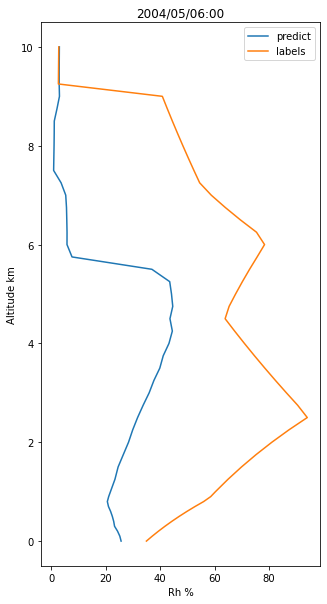

相关系数0.541831


In [20]:
flag = random.randrange(0, data.shape[0])
fig = plt.figure(figsize=(5, 10))
Height = [(int(i)-1965)/1000 for i in labels.columns]
X1 = model.predict(data[flag:flag + 1]).T
X2 = labels[flag:flag + 1].T
# plt.plot(np.abs(X1 - X2), Height, label='X1-X2')
plt.plot(X1, Height, label='predict')
plt.plot(X2, Height, label='labels')
plt.legend()
plt.xlabel('Rh %')
plt.ylabel('Altitude km')
plt.title(test_data.index[flag])
# p = r'I:\Data\Personal_Data\graduation_project\Graduation_thesis\Atlas\Chapter6\\'
# plt.savefig(p+test_data.index[flag].replace('/', '')[:8]+'.png')
plt.show()

print('相关系数{:.6}'.format(np.corrcoef(X1.T, X2.T)[0, 1]))
# print(np.abs(np.mean(X1 - X2).round(4)))
# print('\n')

In [21]:
model.save(r'I:\Data\Personal_Data\graduation_project\Code\Machine_Learning\model_Rh')

INFO:tensorflow:Assets written to: I:\Data\Personal_Data\graduation_project\Code\Machine_Learning\model_Rh\assets
